# Importing the Libraries

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from textblob import Word
from textblob import TextBlob
import inflect
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


# Data Loading and Preprocessing

## Loading the datasets

In [2]:
price_data = "FINAL_DATA/price_data.csv"
zerodha_news_data = "FINAL_DATA/bank_news_zerodha_pulse_~.csv" # Training Data
moneycontrol_news_data = "FINAL_DATA/bank_news_money_control_~.csv" # Testing Data

In [3]:
price_df = pd.read_csv(price_data)
zerodha_news_df = pd.read_csv(zerodha_news_data, sep="~", names=["headline", "date", "Symbol"])
money_control_df = pd.read_csv(moneycontrol_news_data, sep="~", names=["headline", "date", "Symbol"])

In [4]:
combined_data = zerodha_news_df.append(money_control_df)

In [5]:
combined_data = combined_data.merge(price_df, on=["date", "Symbol"])

In [6]:
combined_data = combined_data.drop(["Open Price", "High Price", "Low Price", "Close Price", "Total Traded Quantity"], axis=1)

In [61]:
test_data_df = money_control_df.merge(price_df, on=["date", "Symbol"])

In [62]:
test_data_df = test_data_df.drop(["Open Price", "High Price", "Low Price", "Close Price", "Total Traded Quantity"], axis=1)

In [9]:
combined_data = combined_data.sample(frac=1)

In [64]:
test_data_df = test_data_df[test_data_df.date >= "2019-01-01"]

## Preprocessing Text Data

In [10]:
def clean_text_data_in_df(combined_df):
    combined_df["headlines_cleaned"] = combined_df["headline"].copy()

    ### Lowercasing

    combined_df["headlines_cleaned"] = combined_df["headlines_cleaned"].apply(
        lambda x: " ".join(x.lower() for x in x.split()))

    ### Removing Punctuation

    combined_df["headlines_cleaned"] = combined_df["headlines_cleaned"].str.replace('[^\w\s]','')

    ### Removing stopwords

    stop = stopwords.words('english')
    combined_df["headlines_cleaned"] = combined_df["headlines_cleaned"].apply(
        lambda x: " ".join(x for x in x.split() if x not in stop))

    ### Lemmatization

    combined_df["headlines_cleaned"] = combined_df["headlines_cleaned"].apply(
        lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    ### Tokenisation
    combined_df["headlines_cleaned"] = combined_df["headlines_cleaned"].apply(
        lambda x: list(TextBlob(x).words))

In [ ]:
def preprocess_df(combined_df):
    clean_text_data_in_df(combined_df)
    pp_df = combined_df.copy()
    pp_df = pp_df.sample(frac=1)
    return pp_df

combined_data = preprocess_df(combined_data)
# train_data_df = preprocess_df(train_data_df)

In [65]:
test_data_df = preprocess_df(test_data_df)

## Wordclouds for Headlines

In [12]:
all_words = []
for headline in combined_data["headlines_cleaned"]:
    all_words+=[str(x) for x in headline]

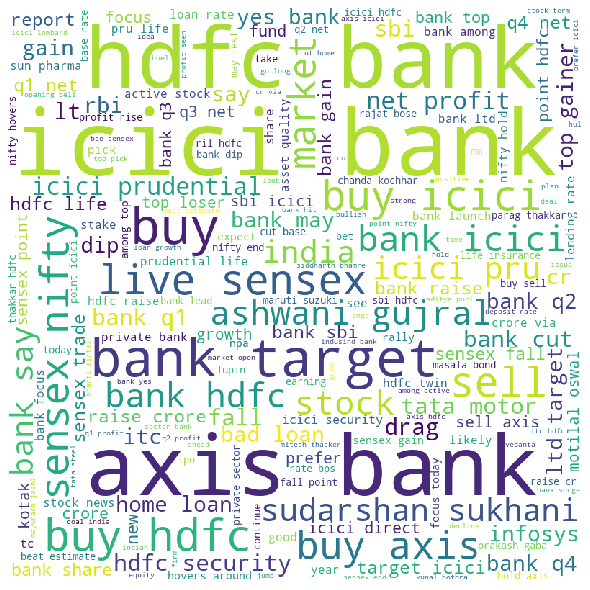

In [13]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(all_words))
# plot the WordCloud image  
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

## TF-IDF

In [14]:
def run_tfidf(data_df):
    corpus = [" ".join(x) for x in data_df["headlines_cleaned"].values]
    vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus)
    idf_values = {key:value for key,value in zip(vectorizer.vocabulary_, vectorizer.idf_)}
    return idf_values

In [15]:
idf_values = run_tfidf(combined_data)

## Word2Vec

In [16]:
w2v_features = 300

In [66]:
# Load Google's pre-trained Word2Vec model.
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('FINAL_DATA/GoogleNews-vectors-negative300.bin', binary=True)

In [67]:
word_vectors = w2v_model.wv

/home/chetan/Documents/BDA LAB/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [68]:
del w2v_model

In [20]:
def get_mean_vector(words):
    combined = []
    for word in words:
        try:
            combined.append(idf_values[word]*word_vectors[word])
        except:
            continue
#             combined.append(np.zeros(w2v_features))
    return np.mean(combined, axis=0)

In [21]:
def run_w2v(pp_df):
    average_word_vectors = pp_df["headlines_cleaned"].apply(lambda x: get_mean_vector(x))
    pp_df["avg_wv"] = average_word_vectors
    pp_df = pp_df.drop(["headlines_cleaned"], axis=1)

In [ ]:
run_w2v(combined_data)

In [69]:
run_w2v(test_data_df)

In [70]:
del word_vectors

In [24]:
combined_data.head()

,headline,date,Symbol,close_price_change,headlines_cleaned,avg_wv
5466,Watch out for revival of US growth and not Chi...,2016-02-04,AXISBANK,1,"[watch, revival, u, growth, chinese, growth, n...","[-0.36037937, 0.20741068, 0.58624965, 1.439678..."
2003,HDFC Q3 net rises 11.5 pct on higher loan growth,2015-01-29,HDFCBANK,1,"[hdfc, q3, net, rise, 115, pct, higher, loan, ...","[-0.5457195, 0.15019812, -0.55186796, 1.360317..."
5772,"RBI slaps Rs 50 lk penalty on ICICI Bank, Rs 2...",2014-12-17,AXISBANK,1,"[rbi, slap, r, 50, lk, penalty, icici, bank, r...","[-0.24143447, -0.1685885, -0.26433918, 0.69442..."
7363,"Buy Axis Bank, Reliance Industries: Sudarshan ...",2014-03-20,AXISBANK,0,"[buy, axis, bank, reliance, industry, sudarsha...","[0.32920757, -0.21408555, -0.65134114, 0.47107..."
3063,"Positive on ITC & ICICI Bank, says Deven Choksey",2016-11-04,ICICIBANK,1,"[positive, itc, icici, bank, say, deven, choksey]","[-0.078077644, -0.15905473, 0.32802582, -0.052..."


In [71]:
test_data_df.head()

,headline,date,Symbol,close_price_change,headlines_cleaned,avg_wv
136,"Stocks in the news: NIIT Tech, Lakshmi Vilas B...",2019-04-08,HDFCBANK,0,"[stock, news, niit, tech, lakshmi, vila, bank,...","[0.5092075, 0.6796649, -0.03359908, -0.0204304..."
331,Stern action against Chanda Kochhar a warning ...,2019-01-31,ICICIBANK,0,"[stern, action, chanda, kochhar, warning, indi...","[-0.7135491, 0.22107586, 0.16430922, 0.5738217..."
499,Spot the next 'HDFC Bank'?,2019-03-08,AXISBANK,0,"[spot, next, hdfc, bank]","[0.27049038, 0.36783725, 0.25932938, 0.3801634..."
132,Sensex falls sharply in late trade; 5 factors ...,2019-04-10,HDFCBANK,0,"[sensex, fall, sharply, late, trade, 5, factor...","[0.9785615, 0.34472078, -0.052026827, 1.175278..."
351,ICICI Prudential surges 9% after strong respon...,2019-03-27,ICICIBANK,0,"[icici, prudential, surge, 9, strong, response...","[-0.17121841, 0.5009158, -0.48050976, 0.738987..."


# Classification Algorithms

### Preparing data for classification

In [34]:
train_test_split = 0.9

In [93]:
X = [attribute_vector.reshape(w2v_features) for attribute_vector in combined_data["avg_wv"].values]

In [92]:
X_test = [attribute_vector.reshape(w2v_features) for attribute_vector in test_data_df["avg_wv"].values]

In [94]:
split_point = int(len(X)*train_test_split)

In [95]:
X_train = X[:split_point]
X_test = X[split_point:]

In [96]:
Y = combined_data["close_price_change"].values

In [97]:
# Y_train = train_data_df["close_price_change"].values
# Y_test = test_data_df["close_price_change"].values
Y_train = Y[:split_point]
Y_test = Y[split_point:]

In [98]:
len(X_train)

6641

In [99]:
len(X_test)

738

## Random Forest

In [42]:
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=20, n_jobs=4)

In [43]:
rf_clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=4, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [44]:
rf_clf.score(X_test, Y_test)*100

66.12466124661248

## Logistic Regression

In [45]:
lr_clf = LogisticRegression(random_state=0, solver='lbfgs')

In [46]:
lr_clf.fit(X_train, Y_train)

/home/chetan/Documents/BDA LAB/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
lr_clf.score(X_test, Y_test)*100

57.72357723577236

## Deep Neural Networks

In [48]:
model = Sequential()
model.add(Dense(256, input_dim=w2v_features, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [49]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
Total params: 114,362
Trainable params: 114,362
Non-trainable params: 0
_________________________________________________________________


In [51]:
Y_train_cat = to_categorical(Y_train)
Y_test_cat = to_categorical(Y_test)

In [54]:
model.fit(np.array(X_train), Y_train_cat, epochs=100, batch_size=10)

Epoch 1/50
6641/6641 [==============================] - 1s 164us/step - loss: 0.1384 - acc: 0.9298
Epoch 2/50
6641/6641 [==============================] - 1s 160us/step - loss: 0.1179 - acc: 0.9377
Epoch 3/50
6641/6641 [==============================] - 1s 160us/step - loss: 0.1252 - acc: 0.9337
Epoch 4/50
6641/6641 [==============================] - 1s 161us/step - loss: 0.1236 - acc: 0.9343
Epoch 5/50
6641/6641 [==============================] - 1s 160us/step - loss: 0.1215 - acc: 0.9339
Epoch 6/50
6641/6641 [==============================] - 1s 158us/step - loss: 0.1140 - acc: 0.9363
Epoch 7/50
6641/6641 [==============================] - 1s 155us/step - loss: 0.1356 - acc: 0.9307
Epoch 8/50
6641/6641 [==============================] - 1s 159us/step - loss: 0.1176 - acc: 0.9342
Epoch 9/50
6641/6641 [==============================] - 1s 161us/step - loss: 0.1148 - acc: 0.9351
Epoch 10/50
6641/6641 [==============================] - 1s 162us/step - loss: 0.1132 - acc: 0.9349
Epoch 11/

In [55]:
scores = model.evaluate(np.array(X_test), Y_test_cat)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

738/738 [==============================] - 0s 21us/step

acc: 65.04%


## SVM Classifier

In [56]:
from sklearn.svm import SVC

In [57]:
svm_clf = SVC(gamma='auto', C=1.0)

In [58]:
svm_clf.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [59]:
svm_clf.score(X_test, Y_test)*100

59.48509485094851

### Confusion Matrix

In [89]:
from sklearn.metrics import confusion_matrix

In [ ]:
tn, fp, fn, tp = confusion_matrix(Y_test, list(rf_clf.predict(X_test))).ravel()

In [101]:
print(tn, fp, fn, tp)

216 144 106 272
